
### <center>Procesamiento Digital de Señales de Audio</center>
#### <center>Instituto de Ingeniería Eléctrica - UdelaR</center>
# Hoja de Ejercicios 3 - Curso 2022
## Análisis de Fourier de tiempo corto
### Procesamiento tiempo-frecuencia


## Pautas para el práctico
 - La realización del presente trabajo es individual.
 - Se espera la entrega de un PDF escrito en $\LaTeX$ o similar. El mismo tendrá:
     - Máximo de 14 páginas
     - Máximo de 2500 palabras
 - También se espera la entrega del código escrito, en scripts Python o en este mismo Jupyter Notebook.
 - La corrección del práctico se hará sobre lo entregado en el PDF, pero podremos apoyarnos en el razonamiento y comprensión demostrado en el código escrito. Recomendamos escribir el código de forma prolija para facilitar la comprensión presente y futura tanto de nosotros como de ustedes mismxs.
 - Los ejercicios marcados como $\blacklozenge$ son opcionales.


**Nombre de el/la estudiante:** Julieta Umpierrez

### Como correr este notebook

Es posible descargarlo y correrlo localmente en su computadora

Tambien pueden correrlo en Google Colab usando el siguiente link.

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/practicos/AudioDSP_Practico_3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Correr en Google Colab</a>
  </td>
</table>

In [ ]:
# Al correr esta celda, se podrá acceder a archivos
# y carpetas en su cuenta de google drive.
# Puede ver la estructura de carpetas apretando en
# el icono de carpeta de la barra lateral izquierda.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.io.wavfile import read
from IPython.display import Audio

# Ejercicio 1

En este ejercicio se estudia la relación entre la transformada de Fourier de tiempo corto y la función de autocorrelación de tiempo corto. Si definimos la densidad espectral de potencia en tiempo corto de una señal ($x[n]$) en función de su transformada de Fourier en tiempo corto como

\begin{equation*}
	S_n(e^{jw}) = |X_n(e^{jw})|^2
\end{equation*}

y la función de autocorrelación de tiempo corto de la señal \(x[n]\) como

\begin{equation*}
	R_n[k] = \sum_{m=-\infty}^{\infty}w[n-m]x[m]w[n-k-m]x[m+k],
\end{equation*}

probar que si

\begin{equation*}
	X_n(e^{jw}) = \sum_{m=-\infty}^{\infty}x[m]w[n-m]e^{-jwm}
\end{equation*}

$R_n[k]$ y $S_n(e^{jw})$ son un par de transformadas, i.e. $S_n(e^{jw})$ es la transformada de Fourier de $R_n[k]$.


# Ejercicio 2

En este ejercicio se estudia un método de detección de frecuencia fundamental (o _pitch_) basado en la transformada de Fourier de tiempo corto. Se sugiere utilizar el archivo _LP-mem-6-a.wav_ para probarlo.

## Parte 1
El producto armónico espectral -Harmonic Product Spectrum, HPS- (ver _Pitch Detection in the Spectral Domain, pág. 623_, en  L. R. Rabiner and R. W. Schafer, _Theory and Applications of Digital Speech Processing_. Prentice Hall, 1st ed., 2011 [1]) está dado por

\begin{equation*}
	P_n(e^{jw}) = \prod_{r=1}^{K}|X_n(e^{jwr})|^2
\end{equation*}

Tomando el logaritmo se obtiene (log-Harmonic Product Spectrum, log-HPS),

\begin{equation*}
	\hat{P}_n(e^{jw}) = 2\sum_{r=1}^{K}\log|X_n(e^{jwr})|
\end{equation*}

Explique por qué el HPS puede usarse para detección de _pitch_. Asuma que la señal de audio es monofónica (una única fuente armónica). ¿Qué ventajas presenta el uso del log-HPS frente al HPS? ¿Qué ocurre con señales cuya frecuencia fundamental está ausente (e.g. filtrado pasa-altos por el canal de comunicación)?


## Parte 2

El espectro logarítmico acumulado (ó GLogS por sus siglas en inglés), se calcula como el promedio de logaritmo de la magnitud del espectro en posiciones armónicas de una frecuencia fundamental $f_0$, como

\begin{equation*}
	\rho_n(f_0) = \frac{1}{n_H}\sum_{i=1}^{n_H}\log|X_n(if_0)|
\end{equation*}

siendo $n_H$ la cantidad de armónicos de $f_0$ cuya frecuencia es menor a cierta frecuencia máxima $f_{\max}$.

Implemente un algoritmo de detección de _pitch_ que calcule el GLogS para valores de $f_0$ distribuidos de forma logarítmica entre $55Hz$ (A1) y $1046.5Hz$ (C6) con un paso de cuarto de tono, y $f_{\max} =  10000Hz$.

In [ ]:
sr, audio = io.wavfile.read('/content/drive/MyDrive/Colab Notebooks/AudioDSP_Files/LP-mem-6-a.wav')
Audio(audio, rate=sr)

In [ ]:
f0s = 55*(2**(1/48))**np.arange(205)
f_max = 10000

In [ ]:
from scipy import signal
from scipy import interpolate

In [ ]:
def GLogS(f_max,f0, Zxxn,fn):
  nh = int(f_max/f0)
  interp = interpolate.interp1d(fn, Zxxn)
  rho = 0
  for i in range(1,nh+1):
    rho = rho+ np.log10(np.abs(interp(i*f0)))
  rho = rho/nh
  return rho

In [ ]:
def analysis_STFT(x, L=2048, R=256, win='hann'):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal

    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.

    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """

    # length of the input signal
    M = x.size;

    # number of points to compute the DFT (FFT)
    N = L

    # analysis window
    window = signal.windows.get_window(win, L)

    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    X_stft = np.zeros((N, num_frames), dtype = complex)

    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        xr = x[n_ini:n_end]*window

        # save DFT of the signal frame
        X_stft[:, ind] = np.fft.fft(xr,N)

    # frequency values in radians
    omega_stft = np.arange(N)*2*np.pi/N

    # time sample at the center of each frame
    samps_stft = np.arange(num_frames)*R + L/2

    return X_stft, omega_stft, samps_stft, num_frames

In [ ]:
X_stft, omega, samps, num_frames = analysis_STFT(audio, L = 1024, R = 256)

In [ ]:
rhos = np.zeros(f0s.shape[0])
Ngrilla = f0s.shape[0]
GLOGS = np.zeros((num_frames,Ngrilla))
stft_freqs = omega*sr/(2*np.pi)
estimacion = np.zeros(num_frames)
for n in range(num_frames):
  #Eligo el frame n esimo
  Xn = X_stft[:,n]
  for i in range(f0s.shape[0]):
    #Para el frame n-esimo calculo el rho para cada frecuencia fundamental posible
    rhos[i] = GLogS(f_max,f0s[i],Xn,stft_freqs)
  #Guardo el vector de rhos como fila de una matriz que va a tener tantas filas como frames
  GLOGS[n,:] = rhos
  #Guardo para cada frame la estimacion de frecuencia fundamental correspondiente al valor maximo de los rhos
  estimacion[n] = f0s[np.argmax(rhos)]

In [ ]:
copia_rhos = rhos.copy()
copia_GLOGS = GLOGS.copy()
copia_estimacion = estimacion.copy()

In [ ]:
pro =np.genfromtxt(fname='/content/drive/MyDrive/Colab Notebooks/AudioDSP_Files/LP-mem-6-a.txt')

In [ ]:
GLOGS.shape

(1497, 205)

Text(0, 0.5, 'Frecuencia fundamental')

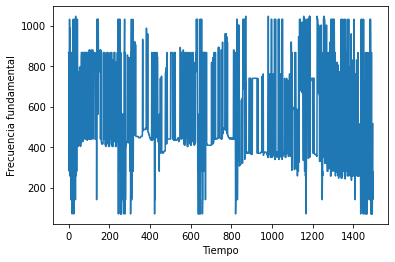

In [ ]:
plt.plot(estimacion)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia fundamental')

In [ ]:
estimacion_post = np.zeros(estimacion.shape[0])
for i in range(estimacion.shape[0]):
  estimacion_post[i] = f0s[np.argmax(GLOGS[i,:150])]

In [ ]:
pro.shape[0]

1597

In [ ]:
estimacion_post.shape

(1497,)

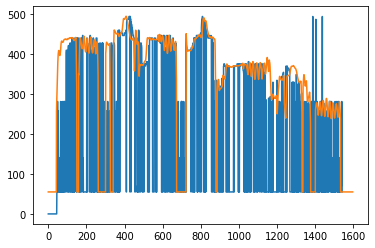

In [ ]:
estimacion_post3 = np.concatenate((np.zeros(45),estimacion))
plt.plot(estimacion_post3)
plt.plot(pro[:,1])

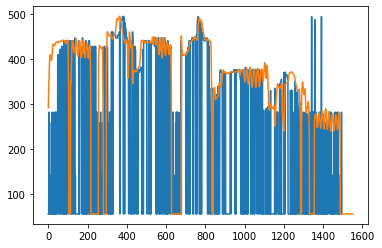

In [ ]:
ref = pro[:,1]
ref_corrido = ref[45:]
plt.plot(estimacion)
plt.plot(ref_corrido)

Text(0, 0.5, 'Frecuencia fundamental')

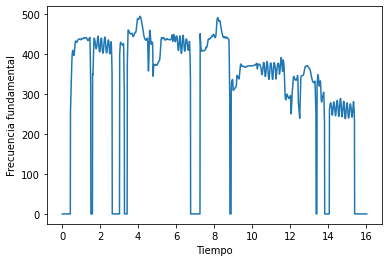

In [ ]:
plt.plot(pro[:,0],pro[:,1])
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia fundamental')

## Parte 3

Utilice el GLogS para obtener una representación tiempo-$f_0$, que denominaremos $f_0$-grama. Compare dicha representación con el espectrograma. Represente la frecuencia fundamental detectada y la frecuencia de referencia en el $f_0$-grama, para el archivo _LP-mem-6-a.wav_.

(0.0, 1000.0)

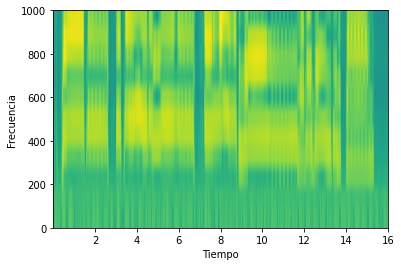

In [ ]:
plt.specgram(audio,Fs=sr)
#plt.plot(pro[:1493,0],estimacion, 'r')
#plt.axhline(1000)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.ylim(0,1000)

In [ ]:
for i in range(estimacion.shape[0]):
  if estimacion_post3[i]<55:
    estimacion_post3[i] = 55
  if estimacion[i]>500:
    estimacion[i] = 55
for i in range(pro.shape[0]):
  if pro[i,1]<55:
    pro[i,1] = 55

Text(0, 0.5, 'Frecuencia')

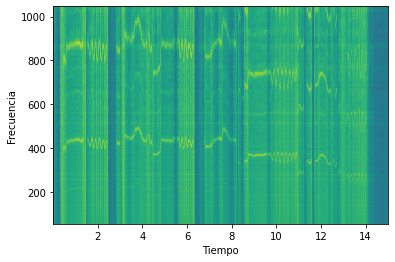

In [ ]:
plt.pcolormesh(pro[:1497,0], f0s, copia_GLOGS.T, vmin=0, shading='gouraud')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

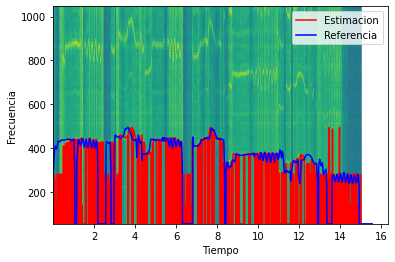

In [ ]:
plt.pcolormesh(pro[:1497,0], f0s, copia_GLOGS.T, vmin=0, shading='gouraud')
plt.plot(pro[:1497,0],estimacion, 'r', label = 'Estimacion')
plt.plot(pro[:1597-45,0],pro[45:,1],'b', label = 'Referencia')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

# Ejercicio 3

En este ejercicio teórico, recordamos la condición la síntesis de la STFT discreta mediante el método Overlap-Add (OLA), de que la suma de las ventanas en el tiempo debe ser igual a una constante, y buscaremos probar que esto se cumple bajo ciertas condiciones para el caso de las ventanas de Hann.

Las ventanas de Hann, comúnmente usadas en análisis y síntesis mediante OLA, se definen para el caso de una ventana de largo 2M+1 de la manera siguiente:

\begin{equation*}
    w_{Hann}[n]=[0.5 + 0.5cos(\pi n/M)]w_r[n]
\end{equation*}

donde $w_r[n]$ es una ventana rectangular que representa el requerimiento de the $w_{Hann}[n]=0$ cuando $|n|>M$. Esta ventana podría ser de la forma

\begin{equation*}
    w_r[n]=
            \begin{cases}
                1, & M \leq n \leq M-1 \\
                0, & \text{en otro caso}.
            \end{cases}
\end{equation*}

## Parte 1
Mostrar que la DTFT de $w_r[n]$ es

\begin{equation*}
    W_r(e^{j\omega}) = \bigg(\frac{1-e^{-j\omega 2M}}{1-e^{-j\omega}}\bigg)e^{j\omega M}
\end{equation*}


## Parte 2
Mostrar que

\begin{equation*}
    W_{Hann}(e^{j\omega}) = 0.5W_r(e^{j\omega}) +0.25 W_r(e^{j(\omega-\pi/M)})+0.25 W_r(e^{j(\omega+\pi/M)})
\end{equation*}

y utilizar el resultado de la parte anterior para obtener una ecuación para $W_{Hann}(e^{j\omega})$ que dependa solamente de $\omega$ y $M$.

## Parte 3
Usar los resultados de las partes anteriores para demostrar que $W_{Hann}(e^{j\omega}) = 0$ para todo $k=1,2,...,M-1$ y por lo tanto es posible una reconstrucción perfecta si $R=M$ o $R=M/2$ (si M/2 es un entero), siendo R el periodo de muestreo (en muestras) en el tiempo de la STFT. Ver cap 7.5 en [1].

## Parte 4
Usar los resultados de las partes 1 y 2 para mostrar que $W_{Hann}(e^{j0}) = M$ y por lo tanto la ganancia de reconstrucción es $C=M/R$

# Ejercicio 4

En este ejercicio se implementa la técnica de phase-vocoder y se la utiliza para generar transformaciones de la señal de audio. Se sugiere utilizar el archivo _singing\_voice.wav_ para probarla.

En la etapa de análisis se calcula la transformada de Fourier de tiempo corto, como

\begin{equation*}
    X_{n_a^u}(e^{j\omega_k})=\sum_{m=-\infty}^{\infty}w_a[n_a^u-m]\, x[m]\, e^{-j\omega_kn}
\end{equation*}

en donde, $w_a[n]$ es la ventana de análisis, $\omega_k=\frac{2\pi}{N} k$, con \(N\) la cantidad de puntos de la DFT, y $n_a^u = u \, R_a$, con $R_a$ el hop de análisis en muestras y $u$ el índice de la trama temporal, de valor inicial 0.

En la etapa de síntesis se reconstruye la señal en el dominio del tiempo mediante la antitransformada de Fourier de cada trama temporal y el procedimiento de solapamiento y suma (overlap-add), como

\begin{equation*}
    y[n]=\sum_{u=-\infty}^{\infty}w_s[n-n_s^u]y_u[n-n_s^u]
\end{equation*}

con

\begin{equation*}
    y_u[n]=\frac{1}{N}\sum_{k=0}^{N-1}Y_{n_s^u}(e^{j\omega_k}) \, e^{j\omega_kn}
\end{equation*}

en donde, $w_s[n]$ es la ventana de síntesis, y $n_s^u=u \, R_s$, siendo $R_s$ el hop de síntesis en muestras. Notar que $y_u[n]$ es la transformada inversa de Fourier de una trama de la STFT. Cuando no hay modificaciones entre la etapa de análisis y síntesis, $Y_{n_s^u}(e^{j\omega_k}) = X_{n_a^u}(e^{j\omega_k})$ y $R_s = R_a$. En ese caso la ventana de síntesis $w_s[n]$ es opcional, pero se hace importante si se aplican modificaciones, por ejemplo cuando $R_s \neq R_a$.  
  
## Parte 1

Implemente el análisis y la síntesis para $Y_{n_s^u}(e^{j\omega_k})=X_{n_a^u}(e^{j\omega_k})$ y $R_s=R_a$. Elija un valor de $R_a$ para tener reconstrucción perfecta con ventana de Hann y verifique experimentalmente. Justifique su elección.

In [ ]:
fs, x = io.wavfile.read('/content/drive/MyDrive/Colab Notebooks/AudioDSP_Files/singing_voice.wav')
Audio(x, rate=fs)

In [ ]:
#Codigo extraido de notebooks de clase
def analysis_STFT(x, L=2048, R=256, win='hann'):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal

    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.

    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """

    # length of the input signal
    M = x.size;

    # number of points to compute the DFT (FFT)
    N = L

    # analysis window
    window = signal.windows.get_window(win, L)

    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    X_stft = np.zeros((N, num_frames), dtype = complex)

    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        xr = x[n_ini:n_end]*window

        # save DFT of the signal frame
        X_stft[:, ind] = np.fft.fft(xr,N)

    # frequency values in radians
    omega_stft = np.arange(N)*2*np.pi/N

    # time sample at the center of each frame
    samps_stft = np.arange(num_frames)*R + L/2

    return X_stft, omega_stft, samps_stft

def synthesis_STFT(X_stft, L=2048, R=256, win='hann'):
    """ compute the synthesis using the IFFT of each frame combined with overlap-add

    Parameters
    ----------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.

    Returns
    -------
    x : numpy array
        output audio signal (mono) as a numpy 1D array.

    """

    # number of frequency bins
    N = X_stft.shape[0];

    # analysis window
    window = signal.windows.get_window(win, L)

    # total number of analysis frames
    num_frames = X_stft.shape[1]

    # initialize otuput signal in the time domain
    y = np.zeros(num_frames * R + L)

    # process each frame
    for ind in range(num_frames):

        # reconstructed signal frame
        yr = np.fft.ifft(X_stft[:,ind], N).real*window

        # initial and ending points of the frame
        n_ini = int(ind*R)
        n_end = n_ini + L

        # overlap-add the signal frame
        y[n_ini:n_end] += yr

    # compute the amplitude scaling factor
    C = np.sum(window*window)/R

    # compensate the amplitude scaling factor
    y /= C

    return y

C =  1.0
max(olawin) =  1.0000000000000004


Text(0.5, 1.0, 'Overlap-add of the analysis windows')

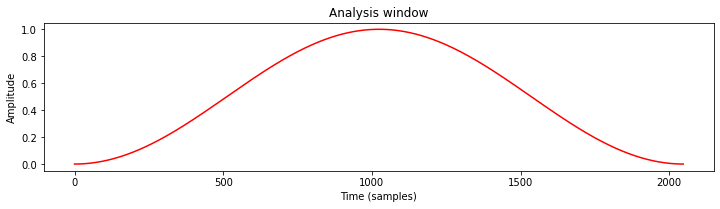

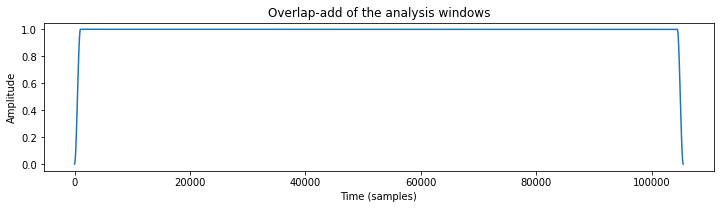

In [ ]:
#Verificacion experimental
# length of the input signal
M = x.size;

# length of the analysis window in samples
L = 2048

# hop size in samples.
R = int(L/2)

# total number of analysis frames
num_frames = int(np.floor((M-L)/R))

# analysis window
window = signal.windows.get_window('hann', L)

# overlap-add (OLA) of the analysis windows
olawin = np.zeros((num_frames-1)*R+L)

# for each analysis frame
for ind in range(num_frames):

    # initial index of current window
    n_ini = ind * R

    # overlap-add the window
    olawin[n_ini:n_ini+L] += window

# compute the amplitude scaling factor
C = np.sum(window)/R #?


print("C = ", C)
print("max(olawin) = ", max(olawin))

# plot the analysis window
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(window, 'r')
plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Analysis window')

# plot the overlap-add of the analysis windows
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(olawin)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Overlap-add of the analysis windows')

Text(0, 0.5, 'AmplitudeY')

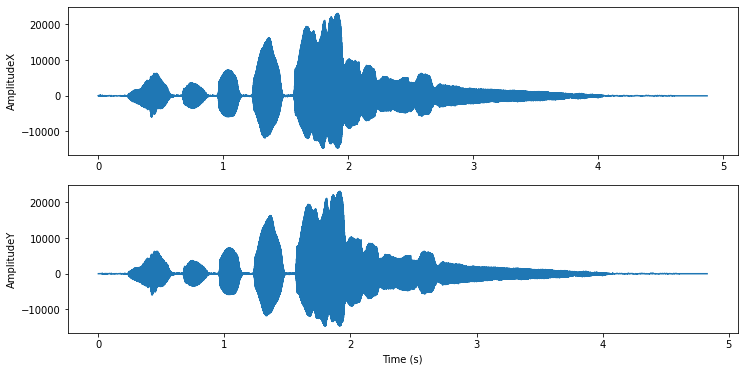

In [ ]:
#Analisis y sintesis
 # window length in samples
L = 2048
# hop size in samples
R = int(L/2)

# compute STFT
X_stft, omega_stft, samps_stft = analysis_STFT(x, L, R, win='hann')

# hop size in samples
R = int(L/2)

# compute the synthesis from the STFT
y = synthesis_STFT(X_stft, L, R, win='hann')
# time corresponding to the audio signal
time_y = np.arange(0, y.size)/fs
time_x = np.arange(0, x.size)/fs
# plot the audio signal waveform
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.ylabel('AmplitudeX')
ax1 = plt.subplot(2, 1, 2)
plt.plot(time_y, y)
plt.xlabel('Time (s)')
plt.ylabel('AmplitudeY')

In [ ]:
Audio(x, rate=fs)

In [ ]:
Audio(y, rate=fs)

## Parte 2

Realice modificaciones de la escala temporal usando $R_s \neq R_a$. En particular pruebe duplicando y reduciendo a la mitad la duración original. Analice los resultados obtenidos y los artefactos que se introducen.

In [ ]:
# window length in samples
L = 2048
# hop size in samples
R = 256

# compute STFT
X_stft, omega_stft, samps_stft = analysis_STFT(x, L, R, win='hann')

# hop size in samples
R = 128

# compute the synthesis from the STFT
y = synthesis_STFT(X_stft, L, R, win='hann')

Text(0, 0.5, 'AmplitudeY')

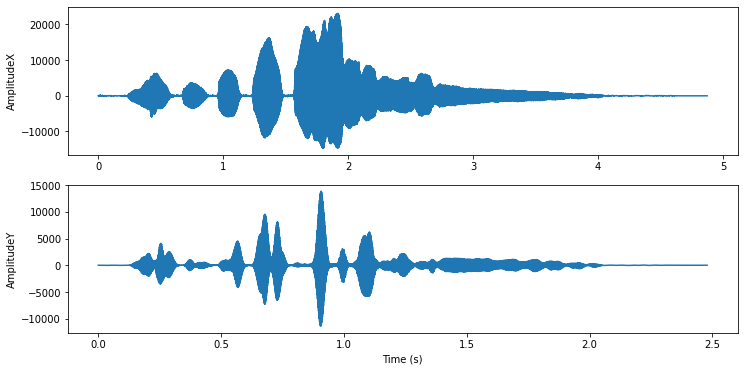

In [ ]:
 # time corresponding to the audio signal
time_y = np.arange(0, y.size)/fs

# plot the audio signal waveform
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.ylabel('AmplitudeX')
ax1 = plt.subplot(2, 1, 2)
plt.plot(time_y, y)
plt.xlabel('Time (s)')
plt.ylabel('AmplitudeY')

In [ ]:
Audio(x, rate=fs)

In [ ]:
Audio(y, rate=fs)

## Parte 3

Para evitar la mayoría de los problemas introducidos debido a la inconsistencia de fase, se sugiere utilizar el procedimiento de desdoblamiento de fase (phase unwrapping).

Asumiendo que existe un solo componente sinusoidal por bin de la DFT, podemos plantear las siguientes ecuaciones para estimar la fase de $Y_{n_s^u}(e^{j\omega_k})$, cuando transformamos la escala temporal utilizando un hop de síntesis $R_s \neq R_a$.

Se calcula el incremento de fase heterodino, a partir del incremento de fase de tramas sucesivas

\begin{equation*}
    \Delta\Phi_k^u=\angle X_{n_a^u}(e^{j\omega_k}) - \angle X_{n_a^{u-1}}(e^{j\omega_k}) - R_a \, \omega_k
\end{equation*}

Notar que el término $R_a\ \omega_k$ es el incremento de fase que cabría esperar si la frecuencia del componente sinusoidal correspondiera exactamente a la frecuencia de análisis.

Se toma el argumento principal de $\Delta\Phi_k^u$ entre ($-\pi, \pi$), que denominamos $\Delta_p\Phi_k^u$.

Luego se calcula la estimación de la frecuencia instantánea

\begin{equation*}
    \hat{\omega}_k[{n^u_a}] = \omega_k + \frac{1}{R_a} \, \Delta_p\Phi_k^u
\end{equation*}

Finalmente se calcula la fase de $Y_{n_s^u}(e^{j\omega_k})$ utilizando la fórmula de propagación de fase

\begin{equation*}
    \angle Y_{n_s^u}(e^{j\omega_k}) = \angle Y_{n_s^{u-1}}(e^{j\omega_k}) + R_s \, \hat{\omega}_k[{n^u_a}]
\end{equation*}

Notar que de acuerdo a la fórmula anterior se hace necesario acumular la fase de tramas sucesivas y establecer un valor para la fase inicial (se sugiere considerar $\angle Y_{n_s^{0}}(e^{j\omega_k}) = \angle X_{n_a^{0}}(e^{j\omega_k})$). Cabe señalar que es importante aplicar una ventana de suavizado $w_s[n]$ en la síntesis. Se sugiere utilizar ventanas de Hann con $w_a[n] = w_s[n]$. Tenga en cuenta que esto modifica el factor de escalamiento temporal. Para profundizar en el estudio de este procedimiento y otras consideraciones sobre la fase se recomienda [2,3].


Implemente el desdoblamiento de fase y compare los resultados con los obtenidos en la parte anterior.

In [ ]:
#Primero definimos una funcion de argumento principal
#Adaptada de funcion propuesta en [3]
def princ_arg(angulo_in):
  k = np.round(angulo_in/(2*np.pi))
  angulo_out = angulo_in - k*2*np.pi
  return angulo_out

In [ ]:
# window length in samples
L = 2048
# hop size in samples
Ra = 256
Rs = 512
M = x.size;
num_frames = int(np.floor((M - L) / Ra))
# compute STFT
X_stft, omega_stft, samps_stft = analysis_STFT(x, L, Ra, win='hann')
#Defino todos los vectores necesarios
num_bins = X_stft.shape[0]
#arg pppal del incremento de fase heterodino
delta_phi = np.zeros((num_bins, num_frames))
#Resultado final
PF = np.zeros((num_bins, num_frames))
#frec instantanea
phase_inc = np.zeros((num_bins,num_frames))
#calculo el wk
omega = omega_stft*Ra
#calculo modulo y fase de la STFT
modulo = np.abs(X_stft)
fase = np.angle(X_stft)
#La primer fase es igual a la original
PF[:,0] = fase[:,0]
for idx in range(1,num_frames):
  ddx = idx - 1
  #Calculo para cada frame todos los delta phi
  delta_phi[:,idx] = princ_arg(fase[:,idx]-fase[:,ddx]-omega[:])
  #Calculo para cada frame todos las frec instantaneas
  phase_inc[:,idx] = (omega[:] + delta_phi[:,idx])/Ra
  #Para el resto de las fases calculo con la ultima ecuacion
  PF[:,idx] = PF[:,ddx] +Rs*phase_inc[:,idx]

#Re escribo la stft con el argumento corregido
Z = modulo*np.exp(1j*PF)
#Z = modulo*np.cos(PF) + 1j*modulo*np.sin(PF)
#Sintetizo la stft con el angulo corregido
y = synthesis_STFT(Z, L, Rs, win='hann')

In [ ]:
Audio(y, rate=fs)

Text(0, 0.5, 'Frecuencia')

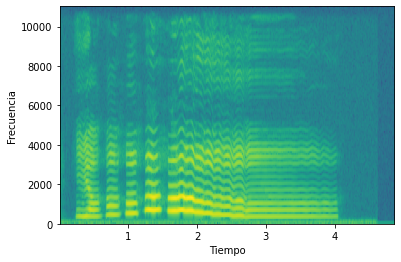

In [ ]:
plt.specgram(x,Fs=fs)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frecuencia')

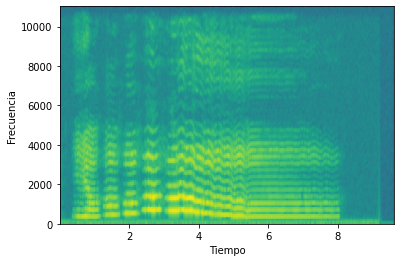

In [ ]:
plt.specgram(y,Fs=fs)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

## Parte 4

Usando el phase-vocoder implemente las siguientes transformaciones de la señal de audio. Incluya en el informe los espectrogramas de las señales generadas y entregue también las señales de audio.

 - **Transposición en frecuencia (pitch-shifting)**: Se desea una señal de la misma duración que la señal original, pero alterando su contenido espectral. Para ello deben realizarse dos acciones complementarias: un escalamiento en el tiempo y un cambio en la frecuencia de muestreo. Por ejemplo, si se desea subir/bajar el contenido espectral de la señal un semitono, se debe aumentar/disminuir la duración de la señal por un factor de $2^{\frac{1}{12}}$, y luego aumentar/disminuir la frecuencia de muestreo por el mismo factor, de modo de obtener una señal de la misma duración que la original.
 - $\blacklozenge$ **Armonizador**: Utilizando el efecto de transposición en frecuencia sumar a la señal original una versión desplazada una quinta (factor de $2^{\frac{7}{12}}\simeq\frac{3}{2}$).
 - $\blacklozenge$ **Coro (_chorus_)**: Consiste en simular que la señal de voz de un único interprete es entonada por varias voces cantando al unísono (es una variación del efecto de armonización). Se deben superponer varias señales con pequeñas modificaciones de _pitch_ respecto al de la señal original y ligeramente distinto para cada uno. El cambio no debe ser mayor que un cuarto de semitono (factor de $2^{\frac{1}{48}}$).

In [ ]:
# window length in samples
L = 2048
# hop size in samples
Ra = 256
Rs = 256*int(2**(1/48))
def phase_vocoder(L,Ra,Rs,x):
  M = x.size;
  num_frames = int(np.floor((M - L) / Ra))
  # compute STFT
  X_stft, omega_stft, samps_stft = analysis_STFT(x, L, Ra, win='hann')
  #Defino todos los vectores necesarios
  num_bins = X_stft.shape[0]
  #arg pppal del incremento de fase heterodino
  delta_phi = np.zeros((num_bins, num_frames))
  #Resultado final
  PF = np.zeros((num_bins, num_frames))
  #frec instantanea
  phase_inc = np.zeros((num_bins,num_frames))
  #calculo el wk
  omega = omega_stft*Ra
  #calculo modulo y fase de la STFT
  modulo = np.abs(X_stft)
  fase = np.angle(X_stft)
  #La primer fase es igual a la original
  PF[:,0] = fase[:,0]
  for idx in range(1,num_frames):
    ddx = idx - 1
    #Calculo para cada frame todos los delta phi
    delta_phi[:,idx] = princ_arg(fase[:,idx]-fase[:,ddx]-omega[:])
    #Calculo para cada frame todos las frec instantaneas
    phase_inc[:,idx] = (omega[:] + delta_phi[:,idx])/Ra
    #Para el resto de las fases calculo con la ultima ecuacion
    PF[:,idx] = PF[:,ddx] +Rs*phase_inc[:,idx]

  #Re escribo la stft con el argumento corregido
  Z = modulo*np.exp(1j*PF)
  #Z = modulo*np.cos(PF) + 1j*modulo*np.sin(PF)
  #Sintetizo la stft con el angulo corregido
  y = synthesis_STFT(Z, L, Rs, win='hann')
  return y

In [ ]:
#PITCH SHIFTING

In [ ]:
# window length in samples
L = 2048
# hop size in samples
Ra = 256
Rs = 256*int(2**(1/12))
y1 = phase_vocoder(L,Ra,Rs,x)

In [ ]:
Audio(y1, rate=fs*(2**(1/12)))

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(0.0, 10000.0)

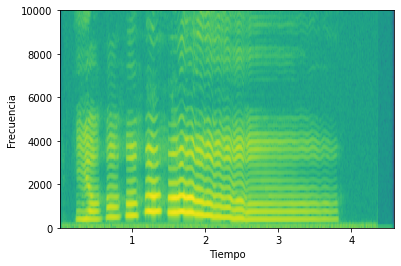

In [ ]:
plt.specgram(y1,Fs=fs*(2**(1/12)))
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.ylim(0,10000)

(0.0, 10000.0)

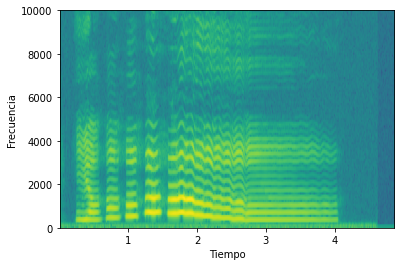

In [ ]:
plt.specgram(x,Fs=fs)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.ylim(0,10000)

In [ ]:
Audio(x, rate=fs)

# Referencias

[1] L. R. Rabiner and R. W. Schafer, *Theory and Applications of Digital Speech Processing*. Prentice
Hall, 1st ed., 2011.

[2] J. Laroche and M. Dolson, “Improved phase vocoder time-scale modification of audio,” *IEEE Transac-
tions on Speech and Audio processing*, vol. 7, no. 3, pp. 323–332, 1999.

[3] A. Gotzen, N. Bernardin, and D. Arfib., “Traditional implementations of a phase-vocoder: The tricks
of the trade,” in *International Conference on Digital Audio Effects, Italy*, Dec. 2000